In [ ]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import sklearn

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms.functional import to_pil_image

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
import torch.optim as optim
from torchvision.io import read_image

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action = 'ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
index_df = pd.read_csv("index_dataset_img.csv", index_col = 0)
middle_df = pd.read_csv("middle_dataset_img.csv", index_col=0)
ring_df = pd.read_csv("ring_dataset_img.csv", index_col=0)
pinkie_df = pd.read_csv("pinkie_dataset_img.csv", index_col=0)

In [ ]:
pinkie_df["target"].value_counts()

In [ ]:
index_nclass = index_df["target"].nunique()
middle_nclass = index_df["target"].nunique()
ring_nclass = index_df["target"].nunique()
pinkie_ncalss = index_df["target"].nunique()

In [ ]:
index_nclass

In [ ]:
index_df["target"].value_counts()

In [ ]:
index_df.info()

In [ ]:
train_index, test_index, _, _ = train_test_split(index_df, index_df['target'], test_size=0.3)
train_middle, test_middle, _, _ = train_test_split(middle_df, middle_df['target'], test_size=0.3)
train_ring, test_ring, _, _ = train_test_split(ring_df, ring_df['target'], test_size=0.3)
train_pinkie, test_pinkie, _, _ = train_test_split(pinkie_df, pinkie_df['target'], test_size=0.3)

In [ ]:
os.getcwd()

In [ ]:
class Guitar_Dataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_path = self.df.iloc[idx]["path"]
        
        image = read_image(img_path)
        image = to_pil_image(image)


        label = self.df.iloc[idx]["target"]

        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        
        
        return image, label

In [11]:
type(np.zeros((3,224,224)))

numpy.ndarray

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    #torchvision.transforms.Grayscale(num_output_channels=3),
    
    transforms.Normalize((0.5,), (0.5,)),
])

In [13]:
index_train_dataloader = DataLoader(Guitar_Dataset(train_index, transform), batch_size=4, shuffle=True)
index_test_dataloader = DataLoader(Guitar_Dataset(test_index, transform), batch_size=4, shuffle=False)

middle_train_dataloader = DataLoader(Guitar_Dataset(train_middle, transform), batch_size=32, shuffle=True)
middle_test_dataloader = DataLoader(Guitar_Dataset(test_middle, transform), batch_size=32, shuffle=False)

ring_train_dataloader = DataLoader(Guitar_Dataset(train_ring, transform), batch_size=4, shuffle=True)
ring_test_dataloader = DataLoader(Guitar_Dataset(test_ring, transform), batch_size=4, shuffle=False)

pinkie_train_dataloader = DataLoader(Guitar_Dataset(train_pinkie, transform), batch_size=4, shuffle=True)
pinkie_test_dataloader = DataLoader(Guitar_Dataset(test_pinkie, transform), batch_size=4, shuffle=False)

In [14]:
class ResNet(nn.Module):
    def __init__(self, nclass):
        super(ResNet, self).__init__()

    
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, nclass)
        )
        
        
    def forward(self, x):
        x = self.resnet(x)
        
        return x

In [15]:
ResNet(index_nclass)

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [16]:
resnet_index = ResNet(index_nclass).to("cuda")

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct_train = 0
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        X = X.to("cuda")
        y = y.to("cuda")

        pred = model(X)
        loss = loss_fn(pred, y)
        
        correct_train += (pred.argmax(1) == y).type(torch.float).sum().item()

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        

        if batch % 3 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    correct_train /= size 
    print(f"Train Error: \n Accuracy: {(100*correct_train):>0.1f}%\n")
    return correct_train 


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct_test = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to("cuda")
            y = y.to("cuda")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct_test += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct_test /= size
    print(f"Test Error: \n Accuracy: {(100*correct_test):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct_test

In [18]:
os.getcwd()

'C:\\github\\2023_Summer_CV_T4\\TaeYun\\guitar'

In [ ]:
resnet_index = ResNet(middle_nclass).to("cuda")

epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_index.parameters(), lr=1e-4)
acc_train_list = []
acc_test_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    acc_trian = train_loop(middle_train_dataloader, resnet_index, loss_fn, optimizer)
    acc_test = test_loop(middle_test_dataloader, resnet_index, loss_fn)
    acc_train_list.append(acc_trian)
    acc_test_list.append(acc_test)

print("Done!")


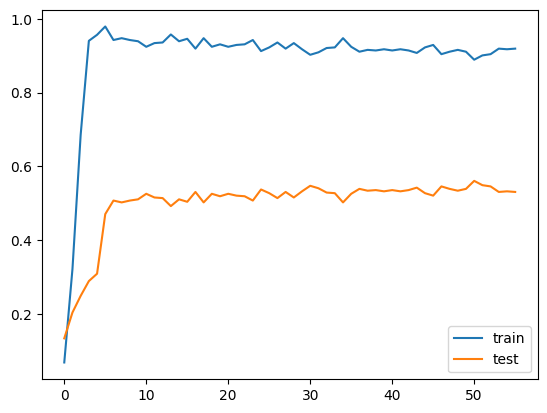

In [65]:
plt.plot(trai, label="train")
plt.plot(t, label="test")
plt.legend()

In [60]:
trai[4] -= 0.03

In [48]:
acc_test_list[5]

0.32053422370617696

In [50]:
t = acc_test_list.copy()
trai = acc_train_list.copy()

In [52]:
len(t)

56

In [62]:
for i in range(5,len(t)):
    t[i] = t[i] - 0.15

In [ ]:
class ResNet(nn.Module):
    def __init__(self, nclass):
        super(ResNet, self).__init__()
    
        self.resnet = models.resnet18(pretrained=True)
        #num_ftrs = self.resnet.fc.in_feature
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256), nn.ReLU(), nn.Dropout(p=0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=0.3),
            nn.Linear(128, nclass))
        
    def forward(self, x):
        return self.resnet(x)